# Observability facilities

Third party software stack to keep an eye on your experiment or gather some metrics.

---

- Website: https://discovery.gitlabpages.inria.fr/enoslib/index.html
- Instant chat: https://framateam.org/enoslib

---

More generally, useful service for the experimentation are consolidated through `Services`.
In particular, EnOSlib has some some Services which deal with the problem of getting some insight on what's running on remote nodes. 

A Service is a python object which exposes three main methods:

- `deploy`: which deploy the service
- `destroy`: remove stop the service
- `backup`: retrieve some states of the services (e.g monitoring information)

Usually a service is used as follow:

```python
service = Service(*args, **kwargs)
service.deploy()
...
# do stuffs
...
service.backup()
service.destroy()
```


But it's sometime useful to use a Context Manager when working with module:

```python
with Service(*args, **kwargs) as service:
    ...
    # do stuffs
    ...
```

This allows for

- running the service for some time depending on what's inside the context manager
- cleaning (and backuping) stuffs automatically at the end

---

**Prerequisites:**
- A Grid'5000 account
- A working EnOSlib environment and Jupyter (not included in EnOSlib dependencies, but `pip install jupyterlab` will install it)
- Some visualization tools: `matplotlib`, `seaborn`
- Packet manipulation tool: `scapy`




## Common setup

In [1]:
import enoslib as en

# get some logging info
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
# claim the resources
network = en.G5kNetworkConf(id="n1", type="prod", roles=["my_network"], site="rennes")

conf = (
    en.G5kConf.from_settings(job_type="allow_classic_ssh", job_name="enoslib_observability")
    .add_network_conf(network)
    .add_machine(
        roles=["control", "xp"], cluster="parasilo", nodes=1, primary_network=network
    )
    .add_machine(
        roles=["agent", "xp"], cluster="parasilo", nodes=1, primary_network=network
    )
    .finalize()
)
conf

Conf@0x7fab4ed3edd0
{
    "dhcp": true,
    "force_deploy": false,
    "env_name": "debian10-x64-nfs",
    "job_name": "enoslib_observability",
    "job_type": "allow_classic_ssh",
    "key": "/home/msimonin/.ssh/id_rsa.pub",
    "queue": "default",
    "walltime": "02:00:00",
    "resources": {
        "machines": [
            {
                "roles": [
                    "control",
                    "xp"
                ],
                "primary_network": "n1",
                "secondary_networks": [],
                "cluster": "parasilo",
                "nodes": 1
            },
            {
                "roles": [
                    "agent",
                    "xp"
                ],
                "primary_network": "n1",
                "secondary_networks": [],
                "cluster": "parasilo",
                "nodes": 1
            }
        ],
        "networks": [
            {
                "id": "n1",
                "type": "prod",
                "roles": [
                    "my_network"
                ],
                "site": "rennes"
            }
        ]
    }
}

In [3]:
provider = en.G5k(conf)
roles, networks = provider.init()
roles

INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from lille
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from luxembourg
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from lyon
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from nancy
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from nantes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from sophia
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Submitting {'name': 'enoslib_observability', 'types': ['allow_classic_ssh'], 'resources': "{cluster='parasilo'}/nodes=1+{cluster='parasilo'}/nodes=1,walltime=02:00:00", 'command': 'sleep 31536000', 'queue': 'default'} on rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Waiting for 1815850 on rennes [2021-08-25 13:41:35]
INFO:enoslib.infra.enos_g5k.g5k_ap

{'control': [Host(address='parasilo-15.rennes.grid5000.fr', alias='parasilo-15.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())], 'xp': [Host(address='parasilo-15.rennes.grid5000.fr', alias='parasilo-15.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set()), Host(address='parasilo-17.rennes.grid5000.fr', alias='parasilo-17.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())], 'agent': [Host(address='parasilo-17.rennes.grid5000.fr', alias='parasilo-17.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())]}

### A simple load generator

We'll install a simple load generator: `stress` available in the debian packages.

In [4]:
with en.actions(roles=roles["agent"]) as a:
    a.apt(name="stress", state="present")

[WARNING]: No inventory was parsed, only implicit localhost is available



PLAY [all] ************************************************************************************************************************************************

TASK [apt] ************************************************************************************************************************************************
 [started TASK: apt on parasilo-17.rennes.grid5000.fr]


[WARNING]: Updating cache and auto-installing missing dependency: python3-apt


ok: [parasilo-17.rennes.grid5000.fr]


## Monitoring with dstat

Dstat is a simple monitoring tool: https://github.com/dstat-real/dstat#information
It runs as a single process and collect metrics from various sources. 
That makes it a good candidate for getting a quick insight on the resources consumptions during an experiment.


The EnOSlib implementation lets you easily 
- start Dstat processes on remote machine and start dumping the metrics into a csv file( it's the purpose `deploy` method of the Dstat service)
- retrieve all the csvs file (one per remote node) on your local machine ( that's the purpose of the `backup` method)
- stop every remote Dstat processes (that's the purpose of the `destroy` method)

### Capture

Let's start with a single capture implemented using a context manager.

In [5]:
# Start a capture on all nodes
# - stress on some nodes
import time
with en.Dstat(nodes=roles["xp"]) as d:
    time.sleep(5)
    en.run_command("stress --cpu 4 --timeout 30", roles=roles["agent"])
    time.sleep(5)
    backup_dir = d.backup_dir


PLAY [all] ************************************************************************************************************************************************

TASK [(tmux list-panes -t __enoslib_dstat__ -F '#{pane_pid}' | xargs -n1 kill -2) || true] ****************************************************************
 [started TASK: (tmux list-panes -t __enoslib_dstat__ -F '#{pane_pid}' | xargs -n1 kill -2) || true on parasilo-15.rennes.grid5000.fr]
 [started TASK: (tmux list-panes -t __enoslib_dstat__ -F '#{pane_pid}' | xargs -n1 kill -2) || true on parasilo-17.rennes.grid5000.fr]
changed: [parasilo-17.rennes.grid5000.fr]
changed: [parasilo-15.rennes.grid5000.fr]

PLAY [all] ************************************************************************************************************************************************

TASK [apt] ************************************************************************************************************************************************
 [started TASK: ap

[WARNING]: Module remote_tmp /root/.ansible/tmp did not exist and was created with a mode of 0700, this may cause issues when running as another user. To
avoid this, create the remote_tmp dir with the correct permissions manually


changed: [parasilo-17.rennes.grid5000.fr]
changed: [parasilo-15.rennes.grid5000.fr]

TASK [Running dstat with the options -aT -o 1629891716952297243-dstat.csv] ********************************************************************************
 [started TASK: Running dstat with the options -aT -o 1629891716952297243-dstat.csv on parasilo-15.rennes.grid5000.fr]
 [started TASK: Running dstat with the options -aT -o 1629891716952297243-dstat.csv on parasilo-17.rennes.grid5000.fr]
changed: [parasilo-15.rennes.grid5000.fr]
changed: [parasilo-17.rennes.grid5000.fr]

PLAY [all] ************************************************************************************************************************************************

TASK [stress --cpu 4 --timeout 30] ************************************************************************************************************************
 [started TASK: stress --cpu 4 --timeout 30 on parasilo-17.rennes.grid5000.fr]
changed: [parasilo-17.rennes.grid5000.fr]

P

### Visualization

All the CSVs files are available under the `backup_dir` inside subdirectories named after the corresponding remote host alias:
```bash
<backup_sir> / host1 / ... / <metrics>.csv
             / host2 / ..../ <metrics>.csv
```
The following bunch of python lines will recursively look for any csv file inside these directories and build a DataFrame and a visualization

In [6]:
import pandas as pd
import seaborn as sns 

#Create a dictionnary of (alias) -> list of pandas df
result = pd.DataFrame()
for host in roles["xp"]:
    host_dir = backup_dir / host.alias
    csvs = host_dir.rglob("*.csv")
    for csv in csvs:
        df = pd.read_csv(csv, skiprows=5, index_col=False)
        df["host"] = host.alias
        df["csv"] = csv
        result = pd.concat([result, df], axis=0)

result

,usr,sys,idl,wai,stl,read,writ,recv,send,in,...,csw,run,blk,new,1m,5m,15m,epoch,host,csv
0,1.124,0.373,98.430,0.073,0,55802.746,875486.983,0,0,0,...,5187.45,0,0,8.971,0.18,0.05,0.01,1.629892e+09,parasilo-15.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
1,0.031,0.000,99.969,0.000,0,0.000,0.000,106,132,0,...,72.00,0,0,0.000,0.18,0.05,0.01,1.629892e+09,parasilo-15.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
2,0.000,0.000,99.969,0.031,0,0.000,143360.000,0,0,0,...,92.00,0,0,1.000,0.18,0.05,0.01,1.629892e+09,parasilo-15.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
3,0.031,0.000,99.969,0.000,0,0.000,0.000,106,2020,0,...,169.00,0,0,0.000,0.16,0.04,0.01,1.629892e+09,parasilo-15.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
4,0.000,0.000,100.000,0.000,0,0.000,0.000,296,228,0,...,83.00,0,0,0.000,0.16,0.04,0.01,1.629892e+09,parasilo-15.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,4.614,0.220,95.166,0.000,0,0.000,0.000,1800,47096,0,...,22462.00,0,0,6.000,1.65,0.41,0.14,1.629892e+09,parasilo-17.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
37,0.031,0.000,99.969,0.000,0,0.000,4096.000,106,0,0,...,1322.00,0,0,0.000,1.65,0.41,0.14,1.629892e+09,parasilo-17.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
38,0.000,0.000,100.000,0.000,0,0.000,0.000,0,0,0,...,74.00,0,0,0.000,1.65,0.41,0.14,1.629892e+09,parasilo-17.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
39,0.000,0.000,100.000,0.000,0,0.000,0.000,288,0,0,...,159.00,0,0,2.000,1.65,0.41,0.14,1.629892e+09,parasilo-17.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...


<AxesSubplot:xlabel='epoch', ylabel='usr'>

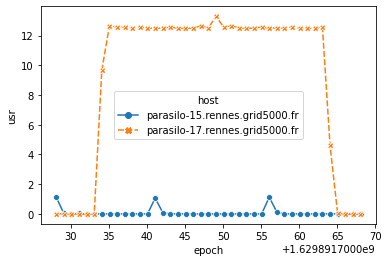

In [7]:
# let's show the metrics !
sns.lineplot(data=result, x="epoch", y="usr", hue="host", markers=True, style="host")

## Packet sniffing with tcpdump

### Capture

In [8]:
# start a capture
# - on all the interface configured on the my_network network
# - we dump icmp traffic only
# - for the duration of the commands (here a client is pigging the server)
with en.TCPDump(
    hosts=roles["xp"], ifnames=["any"], options="icmp"
) as t:
    backup_dir = t.backup_dir
    _ = en.run(f"ping -c10 {roles['control'][0].address}", roles["agent"])


PLAY [all] ************************************************************************************************************************************************

TASK [Stopping tcpdump on any] ****************************************************************************************************************************
 [started TASK: Stopping tcpdump on any on parasilo-15.rennes.grid5000.fr]
 [started TASK: Stopping tcpdump on any on parasilo-17.rennes.grid5000.fr]
changed: [parasilo-15.rennes.grid5000.fr]
changed: [parasilo-17.rennes.grid5000.fr]

TASK [debug] **********************************************************************************************************************************************
 [started TASK: debug on parasilo-15.rennes.grid5000.fr]
 [started TASK: debug on parasilo-17.rennes.grid5000.fr]
ok: [parasilo-15.rennes.grid5000.fr] => {
    "tcpdump_ifs": []
}
ok: [parasilo-17.rennes.grid5000.fr] => {
    "tcpdump_ifs": []
}

TASK [Stopping some tcpdumps] ******************

[WARNING]: Consider using the unarchive module rather than running 'tar'.  If you need to use command because unarchive is insufficient you can add 'warn:
false' to this command task or set 'command_warnings=False' in ansible.cfg to get rid of this message.


changed: [parasilo-15.rennes.grid5000.fr]
changed: [parasilo-17.rennes.grid5000.fr]

TASK [fetch] **********************************************************************************************************************************************
 [started TASK: fetch on parasilo-15.rennes.grid5000.fr]
 [started TASK: fetch on parasilo-17.rennes.grid5000.fr]
changed: [parasilo-15.rennes.grid5000.fr]
changed: [parasilo-17.rennes.grid5000.fr]


### Visualization

In [9]:
from scapy.all import rdpcap
import tarfile
# Examples:
# create a dictionnary of (alias, if) -> list of decoded packets by scapy
decoded_pcaps = dict()
for host in roles["control"]:
    host_dir = backup_dir / host.alias
    t = tarfile.open(host_dir / "tcpdump.tar.gz")
    t.extractall(host_dir / "extracted")
    # get all extracted pcap for this host
    pcaps = (host_dir / "extracted").rglob("*.pcap")
    for pcap in pcaps:
        decoded_pcaps.setdefault((host.alias, pcap.with_suffix("").name),
                                 rdpcap(str(pcap)))

# Displaying some packets
for (host, ifs), packets in decoded_pcaps.items():
    print(host, ifs)
    packets[0].show()
    packets[1].show()

parasilo-15.rennes.grid5000.fr any
###[ cooked linux ]### 
  pkttype   = unicast
  lladdrtype= 0x1
  lladdrlen = 6
  src       = '\\xec\\xf4\\xbb\\xd1\x01\\xb8'
  proto     = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 84
     id        = 45451
     flags     = DF
     frag      = 0
     ttl       = 64
     proto     = icmp
     chksum    = 0x6edc
     src       = 172.16.97.17
     dst       = 172.16.97.15
     \options   \
###[ ICMP ]### 
        type      = echo-request
        code      = 0
        chksum    = 0x5032
        id        = 0x762e
        seq       = 0x1
        unused    = ''
###[ Raw ]### 
           load      = '\\xbf,&a\x00\x00\x00\x00\\x87=\x06\x00\x00\x00\x00\x00\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1c\x1d\x1e\x1f !"#$%&\'()*+,-./01234567'

###[ cooked linux ]### 
  pkttype   = unicast
  lladdrtype= 0x1
  lladdrlen = 6
  src       = '\\xec\\xf4\\xbb\\xd1\x01\\xb8'
  proto     = IPv4
###[ IP ]### 
     

## (TODO) Monitoring with Telegraf/[InfluxDB|promtheus] 

## (TODO) Network observability with Skydive

## Cleaning

In [10]:
provider.destroy()

INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from lille
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from luxembourg
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from lyon
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from nancy
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from nantes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading 1815850 from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from sophia
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Killing the job (rennes, 1815850)
